In [1]:
import os
import pandas as pd
import json
import re

def load_and_pre_process(file_path):
    # Load data
    data = pd.read_csv(file_path, encoding='Windows-1252')

    # Function to extract the score
    def extract_score(score_str):
        match = re.search(r'(\d+)-', score_str)
        if match:
            return int(match.group(1))
        else:
            return None

    # Extract the score part from Home Score and Away Score
    data['Home Score'] = data['Home Score'].apply(extract_score)
    data['Away Score'] = data['Away Score'].apply(extract_score)

    # Function to parse JSON columns
    def parse_json_column(json_str):
        try:
            # Replace single quotes and parse into JSON object
            parsed_data = json.loads(json_str.replace("'", "\""))
            return parsed_data
        except json.JSONDecodeError:
            return None

    # Parse JSON data from four columns
    data['Home Batting Data'] = data['Home Batting Data'].apply(parse_json_column)
    data['Home Bowling Data'] = data['Home Bowling Data'].apply(parse_json_column)
    data['Away Batting Data'] = data['Away Batting Data'].apply(parse_json_column)
    data['Away Bowling Data'] = data['Away Bowling Data'].apply(parse_json_column)

    # Initialize a list to store player data
    player_data = []

    # Extract all player data
    for index, row in data.iterrows():
        # Assume team names can be obtained from 'Home Team' and 'Away Team' columns
        home_team = row.get('Home Team', 'Unknown Home Team')
        away_team = row.get('Away Team', 'Unknown Away Team')

        # Determine the match result
        home_win = 1 if row['Home Score'] > row['Away Score'] else 0
        away_win = 1 - home_win

        # Extract Home Batting and Bowling data
        if isinstance(row['Home Batting Data'], list):
            for player in row['Home Batting Data']:
                if player.get('Name') != 'Total':  # Ignore non-player data like total scores
                    player_data.append({
                        'Name': player.get('Name'),
                        'Role': 'Batsman',
                        'How Out': player.get('How Out'),
                        'Bowled by Bowler': player.get('Bowler').replace('b ', '').strip() if player.get('Bowler') else None,  # Remove 'b ' prefix
                        'Runs': player.get('Runs'),
                        '4s': player.get('4s'),
                        '6s': player.get('6s'),
                        'Balls': player.get('Balls'),
                        'Overs': None,
                        'Maidens': None,
                        'Wickets': None,
                        'Wides': None,
                        'No Balls': None,
                        'Match Index': index,
                        'home_advantage': 1,
                        'team_score': row['Home Score'],
                        'Win': home_win,
                        'team_name': home_team  # Add home team name
                    })

        if isinstance(row['Home Bowling Data'], list):
            for player in row['Home Bowling Data']:
                if player.get('Bowler') != 'Total':  # Ignore non-player data like total scores
                    player_data.append({
                        'Name': player.get('Bowler'),
                        'Role': 'Bowler',
                        'How Out': None,
                        'Bowled by Bowler': None,
                        'Runs': player.get('Runs'),
                        '4s': None,
                        '6s': None,
                        'Balls': None,
                        'Overs': player.get('Overs'),
                        'Maidens': player.get('Maidens'),
                        'Wickets': player.get('Wickets'),
                        'Wides': player.get('Wides'),
                        'No Balls': player.get('No Balls'),
                        'Match Index': index,
                        'home_advantage': 1,
                        'team_score': row['Home Score'],
                        'Win': home_win,
                        'team_name': home_team  # Add home team name
                    })

        # Extract Away Batting and Bowling data
        if isinstance(row['Away Batting Data'], list):
            for player in row['Away Batting Data']:
                if player.get('Name') != 'Total':  # Ignore non-player data like total scores
                    player_data.append({
                        'Name': player.get('Name'),
                        'Role': 'Batsman',
                        'How Out': player.get('How Out'),
                        'Bowled by Bowler': player.get('Bowler').replace('b ', '').strip() if player.get('Bowler') else None,  # Remove 'b ' prefix
                        'Runs': player.get('Runs'),
                        '4s': player.get('4s'),
                        '6s': player.get('6s'),
                        'Balls': player.get('Balls'),
                        'Overs': None,
                        'Maidens': None,
                        'Wickets': None,
                        'Wides': None,
                        'No Balls': None,
                        'Match Index': index,
                        'home_advantage': 0,
                        'team_score': row['Away Score'],
                        'Win': away_win,
                        'team_name': away_team  # Add away team name
                    })

        if isinstance(row['Away Bowling Data'], list):
            for player in row['Away Bowling Data']:
                if player.get('Bowler') != 'Total':  # Ignore non-player data like total scores
                    player_data.append({
                        'Name': player.get('Bowler'),
                        'Role': 'Bowler',
                        'How Out': None,
                        'Bowled by Bowler': None,
                        'Runs': player.get('Runs'),
                        '4s': None,
                        '6s': None,
                        'Balls': None,
                        'Overs': player.get('Overs'),
                        'Maidens': player.get('Maidens'),
                        'Wickets': player.get('Wickets'),
                        'Wides': player.get('Wides'),
                        'No Balls': player.get('No Balls'),
                        'Match Index': index,
                        'home_advantage': 0,
                        'team_score': row['Away Score'],
                        'Win': away_win,
                        'team_name': away_team  # Add away team name
                    })

    # Convert to DataFrame
    player_df = pd.DataFrame(player_data)

    return player_df

def load_all_csv_from_folder(folder_path):
   
    all_data = []

    # Iterate over all CSV files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            print(f"Loading file: {file_path}")
            
            # Load and process each CSV file
            processed_data = load_and_pre_process(file_path)
            
            # Add processed data to the list
            all_data.append(processed_data)

    # Merge all data into a single large DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)
    
    return combined_data

# Example usage
folder_path = r"C:/Users/77977/OneDrive/Desktop/Cricket_data_2023"  # Replace with the path to the folder containing all CSV files
combined_data = load_all_csv_from_folder(folder_path)

# Filter combined data to remove rows where 'Name' is 'Unsure'
combined_data = combined_data[combined_data['Name'] != 'Unsure']
print(combined_data.head())


正在加载文件: C:/Users/77977/OneDrive/Desktop/Cricket_data_2023\Annfield_Plain_CC_-_Under_13_games.csv
正在加载文件: C:/Users/77977/OneDrive/Desktop/Cricket_data_2023\Beamish_and_E._Stanley_CC_-_Under_13_games.csv
正在加载文件: C:/Users/77977/OneDrive/Desktop/Cricket_data_2023\Bill_Quay_CC_-_Under_13_games.csv
正在加载文件: C:/Users/77977/OneDrive/Desktop/Cricket_data_2023\Bishop_Auckland_CC_-_Under_13_B_games.csv
正在加载文件: C:/Users/77977/OneDrive/Desktop/Cricket_data_2023\Bishop_Auckland_CC_-_Under_13_games.csv
正在加载文件: C:/Users/77977/OneDrive/Desktop/Cricket_data_2023\Blaydon_CC_-_Under_13_games.csv
正在加载文件: C:/Users/77977/OneDrive/Desktop/Cricket_data_2023\Boldon_CA_CC_-_Under_13_games.csv
正在加载文件: C:/Users/77977/OneDrive/Desktop/Cricket_data_2023\Brandon_CC,_Durham_-_Under_13_games.csv
正在加载文件: C:/Users/77977/OneDrive/Desktop/Cricket_data_2023\Burnhope_CC_-_Under_13_games.csv
正在加载文件: C:/Users/77977/OneDrive/Desktop/Cricket_data_2023\Burnmoor_CC_-_Under_13_Gold_games.csv
正在加载文件: C:/Users/77977/OneDrive/Desktop/C

In [2]:
import pandas as pd
import numpy as np

# Define a function to calculate contribution (Method 1)
def calculate_contribution(row, runs_per_innings):
    # Initialize batting and bowling contribution values
    batting_contribution = 0
    bowling_contribution = 0
    
    # Check and calculate batting contribution, including the influence of runs per innings
    if row['Role'] == 'Batsman':
        if pd.notna(row['Runs']) and pd.notna(row['Balls']) and row['Runs'] != '' and row['Balls'] != '':
            try:
                runs = float(row['Runs'])
            except ValueError:
                runs = 0
            try:
                balls = float(row['Balls'])
            except ValueError:
                balls = 1  # Prevent division by zero
            strike_rate = (runs / balls) * 100 if balls > 0 else 0
            # Include runs per innings contribution
            runs_per_innings_contribution = runs_per_innings.get(row['Name'], 0)
            batting_contribution = runs + strike_rate + runs_per_innings_contribution

    # Check and calculate bowling contribution
    if row['Role'] == 'Bowler':
        if pd.notna(row['Wickets']) and pd.notna(row['Runs']) and row['Wickets'] != '' and row['Runs'] != '':
            try:
                wickets = float(row['Wickets'])
            except ValueError:
                wickets = 0
            try:
                runs_conceded = float(row['Runs'])
            except ValueError:
                runs_conceded = 0
            try:
                overs = float(row['Overs'])
            except (ValueError, TypeError):
                overs = 1  # Prevent division by zero
            economy_rate = runs_conceded / overs if overs > 0 else 0
            bowling_contribution = (wickets * 20) - (economy_rate * 5)
    
    # Return the total contribution
    return batting_contribution + bowling_contribution

# Apply the function to calculate each player's contribution

# First, calculate the average runs per innings
batsman_total_runs = combined_data[combined_data['Role'] == 'Batsman'].groupby('Name')['Runs'].apply(lambda x: pd.to_numeric(x, errors='coerce').sum()).reset_index()
batsman_innings = combined_data[combined_data['Role'] == 'Batsman'].groupby('Name')['Name'].count().reset_index(name='Innings')
batsman_runs_per_innings = pd.merge(batsman_total_runs, batsman_innings, on='Name')
batsman_runs_per_innings['Runs per Innings'] = batsman_runs_per_innings['Runs'] / batsman_runs_per_innings['Innings']

# Create a dictionary for lookup of each player's average runs per innings
runs_per_innings_dict = dict(zip(batsman_runs_per_innings['Name'], batsman_runs_per_innings['Runs per Innings']))

# Calculate contribution, including runs per innings contribution for batsmen
combined_data['Contribution'] = combined_data.apply(lambda row: calculate_contribution(row, runs_per_innings_dict), axis=1)

# Extract batsman and bowler data separately
batsman_data = combined_data[combined_data['Role'] == 'Batsman']
bowler_data = combined_data[combined_data['Role'] == 'Bowler']

# Calculate total contribution and number of matches for batsmen, keeping team information
batsman_total_contribution = batsman_data.groupby(['Name', 'team_name'])['Contribution'].sum().reset_index(name='Total Contribution')
batsman_matches_played = batsman_data.groupby(['Name', 'team_name'])['Name'].count().reset_index(name='Matches Played')

# Merge total contribution and matches played, and calculate average contribution
batsman_contribution_stats = pd.merge(batsman_total_contribution, batsman_matches_played, on=['Name', 'team_name'])
batsman_contribution_stats['Contribution_method1'] = batsman_contribution_stats['Total Contribution'] / batsman_contribution_stats['Matches Played']

# Sort the results and simplify the output (Name, team, and contribution)
batsman_results = batsman_contribution_stats[['Name', 'team_name', 'Contribution_method1']].sort_values(by='Contribution_method1', ascending=False)

# Calculate total contribution and number of matches for bowlers, keeping team information
bowler_total_contribution = bowler_data.groupby(['Name', 'team_name'])['Contribution'].sum().reset_index(name='Total Contribution')
bowler_matches_played = bowler_data.groupby(['Name', 'team_name'])['Name'].count().reset_index(name='Matches Played')

# Merge total contribution and matches played, and calculate average contribution
bowler_contribution_stats = pd.merge(bowler_total_contribution, bowler_matches_played, on=['Name', 'team_name'])
bowler_contribution_stats['Contribution_method1'] = bowler_contribution_stats['Total Contribution'] / bowler_contribution_stats['Matches Played']

# Sort the results and simplify the output (Name, team, and contribution)
bowler_results = bowler_contribution_stats[['Name', 'team_name', 'Contribution_method1']].sort_values(by='Contribution_method1', ascending=False)

# Get the top 10 batsmen
top_10_batsmen = batsman_results.head(10)
print("Top 10 Batsmen by Average Contribution (Method 1):")
print(top_10_batsmen)

# Get the top 10 bowlers
top_10_bowlers = bowler_results.head(10)
print("\nTop 10 Bowlers by Average Contribution (Method 1):")
print(top_10_bowlers)


击球手平均贡献值（方法一）前十名：
                      Name                            team_name  \
3989          Oscar Potts*          Burnmoor CC - Under 13 Gold   
3659        Nell Grahamâ€           Burnmoor CC - Under 13 Gold   
4479              T Oliver                  Lintz CC - Under 13   
2522           Joe Brookes             Ushaw Moor CC - Under 13   
788        Cialan McCarthy  Seaham Harbour CC - Under 13 Yellow   
4554         Thomas Ingram              Greenside CC - Under 13   
772   Christopher Bennett*       Durham City CC - Under 13 Gold   
1785         Harry Simpson     Hetton Lyons CC - Under 13 Green   
1790     Harry Simpson*â€   Seaham Harbour CC - Under 13 Yellow   
2671             Josh Grey                  Lintz CC - Under 13   

      Contribution_method1  
3989            423.000000  
3659            412.666667  
4479            406.444444  
2522            359.000000  
788             328.000000  
4554            324.098901  
772             301.857143  
1785        

In [3]:
import pandas as pd
import numpy as np

# Method 2: Contribution calculation including opponent performance
def calculate_contribution_with_opponent_performance(row, bowling_performance, mean_runs, runs_per_innings):
    # Initialize batting and bowling contribution values
    batting_contribution = 0
    bowling_contribution = 0
    
    # Calculate batting contribution
    if row['Role'] == 'Batsman' and pd.notna(row['Runs']) and row['Runs'] != '':
        runs = float(row['Runs']) if row['Runs'] != '' else 0
        balls = float(row['Balls']) if row['Balls'] != '' else 1
        if pd.isna(row['How Out']) or row['How Out'] == 'not out':
            # Not out and runs higher than average, increase contribution
            if runs > mean_runs:
                batting_contribution += runs * 1.5
            else:
                batting_contribution += runs
        else:
            batting_contribution += runs

        # Adjust contribution using runs per innings
        player_name = row['Name']
        if player_name in runs_per_innings:
            runs_per_inning_value = runs_per_innings[player_name]
            # If player's runs per innings is higher than average, increase contribution
            if runs_per_inning_value > mean_runs:
                batting_contribution += runs_per_inning_value * 0.5
        
        # Adjust batting contribution based on bowler's performance
        if pd.notna(row['Bowled by Bowler']):
            bowler_name = row['Bowled by Bowler']
            if bowler_name in bowling_performance:
                # The higher the bowler's performance score, the less the batsman's contribution is reduced
                bowling_performance_score = bowling_performance[bowler_name]
                batting_contribution -= max(0, (50 - bowling_performance_score))
            else:
                # If no bowler performance data, apply default reduction
                batting_contribution -= 10
    
    # Calculate bowling contribution
    if row['Role'] == 'Bowler' and pd.notna(row['Wickets']) and row['Wickets'] != '':
        wickets = float(row['Wickets'])
        runs_conceded = float(row['Runs']) if row['Runs'] != '' else 0
        overs = float(row['Overs']) if row['Overs'] != '' else 1
        economy_rate = runs_conceded / overs if overs > 0 else 0
        bowling_contribution = (wickets * 20) - (economy_rate * 5)
    
    return batting_contribution + bowling_contribution

def calculate_bowler_performance(player_df):
    """
    Calculate performance scores for each bowler.
    """
    bowler_performance = {}
    for _, row in player_df.iterrows():
        if row['Role'] == 'Bowler' and pd.notna(row['Wickets']) and row['Wickets'] != '':
            wickets = float(row['Wickets'])
            runs_conceded = float(row['Runs']) if row['Runs'] != '' else 0
            overs = float(row['Overs']) if row['Overs'] != '' else 1
            economy_rate = runs_conceded / overs if overs > 0 else 0
            performance_score = wickets * 10 - economy_rate
            bowler_name = row['Name']
            if bowler_name not in bowler_performance:
                bowler_performance[bowler_name] = 0
            bowler_performance[bowler_name] += performance_score
    return bowler_performance

# Calculate runs per innings
def calculate_runs_per_innings(player_df):
    batsman_total_runs = player_df[player_df['Role'] == 'Batsman'].groupby('Name')['Runs'].apply(lambda x: pd.to_numeric(x, errors='coerce').sum()).reset_index()
    batsman_innings = player_df[player_df['Role'] == 'Batsman'].groupby('Name')['Name'].count().reset_index(name='Innings')
    batsman_runs_per_innings = pd.merge(batsman_total_runs, batsman_innings, on='Name')
    batsman_runs_per_innings['Runs per Innings'] = batsman_runs_per_innings['Runs'] / batsman_runs_per_innings['Innings']
    
    # Create a dictionary for quick lookup of each player's average runs per innings in contribution calculation
    return dict(zip(batsman_runs_per_innings['Name'], batsman_runs_per_innings['Runs per Innings']))

# Assuming combined_data is your dataset
player_df = combined_data.copy()

# Get the unique match indices
match_indices = player_df['Match Index'].unique()

# Calculate average runs per innings
runs_per_innings_dict = calculate_runs_per_innings(player_df)

# Iterate over each match and calculate contribution using method 2
for match_index in match_indices:
    match_data = player_df[player_df['Match Index'] == match_index]
    bowler_performance = calculate_bowler_performance(match_data)
    
    # Calculate the average runs for all players (excluding non-numeric data)
    valid_runs = pd.to_numeric(match_data[match_data['Role'] == 'Batsman']['Runs'], errors='coerce')
    mean_runs = valid_runs.mean()
    
    # Calculate contribution for each player using method 2 and store it in the `Contribution_method2` column
    player_df.loc[player_df['Match Index'] == match_index, 'Contribution_method2'] = match_data.apply(
        calculate_contribution_with_opponent_performance, axis=1, bowling_performance=bowler_performance, mean_runs=mean_runs, runs_per_innings=runs_per_innings_dict
    )

# Separate batsmen and bowlers for ranking

# Calculate total contribution and matches played for batsmen
batsman_df = player_df[player_df['Role'] == 'Batsman']
batsman_total_contribution = batsman_df.groupby(['Name', 'team_name'])['Contribution_method2'].sum().reset_index(name='Total Contribution')
batsman_matches_played = batsman_df.groupby(['Name', 'team_name'])['Name'].count().reset_index(name='Matches Played')

# Merge total contribution and matches played, and calculate average contribution
batsman_ranking = pd.merge(batsman_total_contribution, batsman_matches_played, on=['Name', 'team_name'])
batsman_ranking['Contribution_method2'] = batsman_ranking['Total Contribution'] / batsman_ranking['Matches Played']
batsman_ranking = batsman_ranking[['Name', 'team_name', 'Contribution_method2']].sort_values(by='Contribution_method2', ascending=False)

# Calculate total contribution and matches played for bowlers
bowler_df = player_df[player_df['Role'] == 'Bowler']
bowler_total_contribution = bowler_df.groupby(['Name', 'team_name'])['Contribution_method2'].sum().reset_index(name='Total Contribution')
bowler_matches_played = bowler_df.groupby(['Name', 'team_name'])['Name'].count().reset_index(name='Matches Played')

# Merge total contribution and matches played, and calculate average contribution
bowler_ranking = pd.merge(bowler_total_contribution, bowler_matches_played, on=['Name', 'team_name'])
bowler_ranking['Contribution_method2'] = bowler_ranking['Total Contribution'] / bowler_ranking['Matches Played']
bowler_ranking = bowler_ranking[['Name', 'team_name', 'Contribution_method2']].sort_values(by='Contribution_method2', ascending=False)

# Get the top 10 batsmen (Method 2)
top_10_batsmen_method2 = batsman_ranking.head(10)
print("Top 10 Batsmen by Average Contribution (Method 2):")
print(top_10_batsmen_method2)

# Get the top 10 bowlers (Method 2)
top_10_bowlers_method2 = bowler_ranking.head(10)
print("\nTop 10 Bowlers by Average Contribution (Method 2):")
print(top_10_bowlers_method2)


击球手平均贡献值（方法二）前十名：
                  Name                                    team_name  \
1107      Ella Jackson                     Whitburn CC - Under 13 A   
1555   George Stewart*                      Tynemouth CC - Under 13   
1660     Harry Blythe*                    Seaham Park CC - Under 13   
3809       Oliver Hall                    Burnopfield CC - Under 13   
931       Danny Norman                    Seaham Park CC - Under 13   
2673     Josh Lane*â€   Washington CC, Durham - Washington U13 Nova   
3782  Oliver Alexander                 Shotley Bridge CC - Under 13   
3812       Oliver Hall                South Shields CC - Under 13 B   
1785     Harry Simpson             Hetton Lyons CC - Under 13 Green   
3305   Marley Robinson                 Annfield Plain CC - Under 13   

      Contribution_method2  
1107             81.966667  
1555             78.000000  
1660             66.681818  
3809             63.428571  
931              60.750000  
2673             60.000000

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.hist(batsman_results['Contribution_method1'], bins=20, alpha=0.75, edgecolor='black')
plt.title('Distribution of Batsmen Contribution (Method 1)')
plt.xlabel('Contribution (Method 1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(bowler_results['Contribution_method1'], bins=20, alpha=0.75, edgecolor='black')
plt.title('Distribution of Bowlers Contribution (Method 1)')
plt.xlabel('Contribution (Method 1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [4]:
# Step 1: Add the average contribution from Method 1 (Contribution_method1) to combined_data
contribution_method1 = pd.concat([batsman_results[['Name', 'team_name', 'Contribution_method1']],
                                  bowler_results[['Name', 'team_name', 'Contribution_method1']]])

# Merge Method 1 contribution values
combined_data = combined_data.merge(
    contribution_method1,
    on=['Name', 'team_name'],
    how='left'
)

# Step 2: Add the average contribution from Method 2 (Contribution_method2) to combined_data
contribution_method2 = pd.concat([batsman_ranking[['Name', 'team_name', 'Contribution_method2']],
                                  bowler_ranking[['Name', 'team_name', 'Contribution_method2']]])

# Merge Method 2 contribution values
combined_data = combined_data.merge(
    contribution_method2,
    on=['Name', 'team_name'],
    how='left'
)

# Remove the redundant 'Contribution' column if it exists
if 'Contribution' in combined_data.columns:
    combined_data = combined_data.drop(columns=['Contribution'])

# Output the final result, checking the first few rows of combined_data
print(combined_data.head())


           Name     Role            How Out   Bowled by Bowler Runs 4s 6s  \
0  Toby Davison  Batsman  ct Jack Wilkinson  Benjamin Thompson   19  1  0   
1  Toby Davison  Batsman  ct Jack Wilkinson  Benjamin Thompson   19  1  0   
2  Toby Davison  Batsman  ct Jack Wilkinson  Benjamin Thompson   19  1  0   
3  Toby Davison  Batsman  ct Jack Wilkinson  Benjamin Thompson   19  1  0   
4  Luke Burton*  Batsman                          Archie Potts   10  1  0   

  Balls Overs Maidens Wickets Wides No Balls  Match Index  home_advantage  \
0    28  None    None    None  None     None            0               1   
1    28  None    None    None  None     None            0               1   
2    28  None    None    None  None     None            0               1   
3    28  None    None    None  None     None            0               1   
4    21  None    None    None  None     None            0               1   

   team_score  Win                     team_name  Contribution_method1  \


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

def build_and_evaluate_model_rf(player_df):
    # Add new features: Contribution_method1, Contribution_method2, Economy Rate, Runs per Innings
    player_df['Economy Rate'] = pd.to_numeric(player_df['Runs'], errors='coerce') / pd.to_numeric(player_df['Overs'], errors='coerce').replace(0, np.nan)
    player_df['Runs per Innings'] = pd.to_numeric(player_df['Runs'], errors='coerce') / pd.to_numeric(player_df['Balls'], errors='coerce').replace(0, np.nan)

    # Select features and target, including Contribution_method1 and Contribution_method2
    features = player_df[['Runs', '4s', '6s', 'Balls', 'Overs', 'Wickets', 'Maidens', 'team_score', 'home_advantage', 'Contribution_method1', 'Contribution_method2', 'Economy Rate', 'Runs per Innings']]
    features = features.apply(pd.to_numeric, errors='coerce')  # Convert all features to numeric
    target = player_df['Win'].astype(int)

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    features = imputer.fit_transform(features)

    # Feature scaling
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    features_resampled, target_resampled = smote.fit_resample(features, target)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(features_resampled, target_resampled, test_size=0.2, random_state=42)

    # Use RandomForest classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_model.fit(X_train, y_train)

    # Use cross-validation scoring
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=3)
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", cv_scores.mean())

    # Predict on the test set
    y_pred = rf_model.predict(X_test)

    # Model evaluation
    print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Return the model and scaler
    return rf_model, scaler

# Call the function by passing the processed dataset
model_rf, scaler = build_and_evaluate_model_rf(combined_data)


Cross-validation scores: [0.93669572 0.93462017 0.93164049]
Mean cross-validation score: 0.9343187961922851
Random Forest Accuracy: 0.9552624296651601
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      5465
           1       0.96      0.95      0.95      5376

    accuracy                           0.96     10841
   macro avg       0.96      0.96      0.96     10841
weighted avg       0.96      0.96      0.96     10841



In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

# Calculate bowler performance for a given match
def calculate_bowler_performance(match_data):
    bowler_performance = {}
    for _, row in match_data.iterrows():
        if row['Role'] == 'Bowler' and pd.notna(row['Wickets']):
            bowler_name = row['Name']
            wickets = float(row['Wickets']) if row['Wickets'] != '' else 0
            runs = float(row['Runs']) if row['Runs'] != '' else 0
            overs = float(row['Overs']) if row['Overs'] != '' else 1
            economy_rate = runs / overs if overs > 0 else 0
            bowler_performance[bowler_name] = {
                'wickets': wickets,
                'economy_rate': economy_rate
            }
    return bowler_performance

# Calculate the contribution of a player to a match, adjusting for opponent performance
def calculate_contribution(row, player_df, model, scaler, poly, bowler_performance):
   
    # Copy the data for modification
    modified_data = player_df.copy()
    
    # Find the match the player participated in
    match_index = row['Match Index']
    
    # Set the player's performance to zero to simulate absence from the match
    if row['Role'] == 'Batsman' and pd.notna(row['Runs']):
        modified_data.loc[modified_data.index == row.name, 'Runs'] = 0
    if row['Role'] == 'Bowler' and pd.notna(row['Wickets']):
        modified_data.loc[modified_data.index == row.name, 'Wickets'] = 0
    
    # Extract the match data
    match_data = player_df[player_df['Match Index'] == match_index]
    modified_match_data = modified_data[modified_data['Match Index'] == match_index]
    
    # Extract features and scale them
    features = ['Runs', '4s', '6s', 'Balls', 'Overs', 'Wickets', 'Maidens', 'team_score', 'home_advantage']
    X_actual = scaler.transform(match_data[features].apply(pd.to_numeric, errors='coerce').fillna(0).values)
    X_modified = scaler.transform(modified_match_data[features].apply(pd.to_numeric, errors='coerce').fillna(0).values)
    
    # Add polynomial features
    X_actual_poly = poly.transform(X_actual)
    X_modified_poly = poly.transform(X_modified)
    
    # Predict the match outcome probabilities using the Random Forest model
    prob_actual = model.predict_proba(X_actual_poly)[:, 1].mean()
    prob_modified = model.predict_proba(X_modified_poly)[:, 1].mean()
    
    # Contribution is the difference in probabilities
    contribution = prob_actual - prob_modified
    
    # Adjust the contribution based on the strength of the opponent
    if row['Role'] == 'Batsman' and 'How Out' in row and pd.notna(row['How Out']) and row['How Out'] != 'not out':
        if pd.notna(row['Bowled by Bowler']):
            bowler_name = row['Bowled by Bowler']
            if bowler_name in bowler_performance:
                bowler_stats = bowler_performance[bowler_name]
                if bowler_stats['wickets'] > 2:  # Assume a strong bowler if more than 2 wickets
                    contribution *= 0.8  # Reduce penalty if dismissed by a strong bowler
                else:
                    contribution *= 0.5  # Increase penalty if dismissed by a weaker bowler
    
    return contribution

# Apply contribution calculation for all players, considering opponent performance
def apply_contribution_calculation_with_opponent(player_df, model, scaler, poly):
   
    # Calculate bowler performance for each match
    for match_index in tqdm(player_df['Match Index'].unique(), desc="Processing Matches"):  # Display progress bar with tqdm
        match_data = player_df[player_df['Match Index'] == match_index]
        bowler_performance = calculate_bowler_performance(match_data)
        
        # Calculate each player's contribution, adjusting for opponent strength
        player_df.loc[player_df['Match Index'] == match_index, 'contribute_method3'] = match_data.apply(
            calculate_contribution, axis=1, player_df=player_df, model=model, scaler=scaler, poly=poly, bowler_performance=bowler_performance
        )
    
    return player_df

# Train the Random Forest model
def train_random_forest(player_df):
    # Select features and labels
    features = player_df[['Runs', '4s', '6s', 'Balls', 'Overs', 'Wickets', 'Maidens', 'team_score', 'home_advantage']]
    features = features.apply(pd.to_numeric, errors='coerce')  # Convert all features to numeric
    target = player_df['Win'].astype(int)

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    features = imputer.fit_transform(features)

    # Feature scaling
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # Add polynomial features
    poly = PolynomialFeatures(degree=2)
    features_poly = poly.fit_transform(features)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(features_poly, target, test_size=0.2, random_state=42)

    # Train the Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    accuracy = model.score(X_test, y_test)
    print("Random Forest Accuracy:", accuracy)

    return model, scaler, poly


In [10]:
# Train the model using the entire dataset
model, scaler, poly = train_random_forest(combined_data)

# Calculate the contribute_method3 for all players
combined_data_with_contributions = apply_contribution_calculation_with_opponent(combined_data, model, scaler, poly)

# Print the first few rows of the data with calculated contributions
print(combined_data_with_contributions[['Name', 'contribute_method3']].head())

Random Forest Accuracy: 0.9503909158600149


Processing Matches: 100%|███████████████████████████████████████████████████████████| 19/19 [1:36:27<00:00, 304.63s/it]


KeyError: "['contribute_method3'] not in index"

In [24]:
import pandas as pd

# Step 1: Check if the 'Contribution' column exists in the dataframe
print("Checking if 'Contribution' column exists:")
print(combined_data_with_contributions[['Name', 'team_name', 'Contribution']].head())

# Step 2: Calculate each player's total contribution and the number of matches played
player_total_contribution = combined_data_with_contributions.groupby(['Name', 'team_name'])['Contribution'].sum().reset_index(name='Total Contribution')
player_matches_played = combined_data_with_contributions.groupby(['Name', 'team_name'])['Name'].count().reset_index(name='Matches Played')

# Step 3: Merge total contribution and the number of matches played
player_contribution_stats = pd.merge(player_total_contribution, player_matches_played, on=['Name', 'team_name'])

# Step 4: Calculate each player's average contribution (Contribution_method3)
player_contribution_stats['Contribution_method3'] = player_contribution_stats['Total Contribution'] / player_contribution_stats['Matches Played']

# Step 5: Add Contribution_method3 back to the original combined_data_with_contributions dataframe
combined_data_with_contributions = pd.merge(
    combined_data_with_contributions,
    player_contribution_stats[['Name', 'team_name', 'Contribution_method3']],
    on=['Name', 'team_name'],
    how='left',
    suffixes=('', '_new')  # Ensure no duplicate columns during merge
)

# Step 6: Sort by Contribution_method3 and select the top 10 players
top_10_players = pd.merge(
    player_contribution_stats.sort_values(by='Contribution_method3', ascending=False).head(10),
    combined_data_with_contributions[['Name', 'team_name', 'Role']].drop_duplicates(),
    on=['Name', 'team_name'],
    how='left'
)

# Step 7: Output the top 10 players by Name, team_name, Role, and Contribution_method3
print("Top 10 players ranked by Contribution_method3:")
print(top_10_players[['Name', 'team_name', 'Role', 'Contribution_method3']])


Checking if 'Contribution' column exists:
           Name                     team_name  Contribution
0  Toby Davison  Annfield Plain CC - Under 13      0.000004
1  Toby Davison  Annfield Plain CC - Under 13      0.000004
2  Toby Davison  Annfield Plain CC - Under 13      0.000004
3  Toby Davison  Annfield Plain CC - Under 13      0.000004
4  Luke Burton*  Annfield Plain CC - Under 13      0.000022
球员 Contribution_method3 排行前 10 名：
                   Name                            team_name     Role  \
0            Will Makin            Seaham Park CC - Under 13  Batsman   
1           Thomas Carr  Seaham Harbour CC - Under 13 Yellow  Batsman   
2       Joseph Bruceâ€             Seaham Park CC - Under 13  Batsman   
3        Jacob Wheatley         Dawdon Welfare CC - Under 13   Bowler   
4        Will Makin*â€             Seaham Park CC - Under 13  Batsman   
5         Arthur Tipton       Durham City CC - Under 13 Gold   Bowler   
6       Cevat Sahin*â€          Dawdon Welfare CC - U

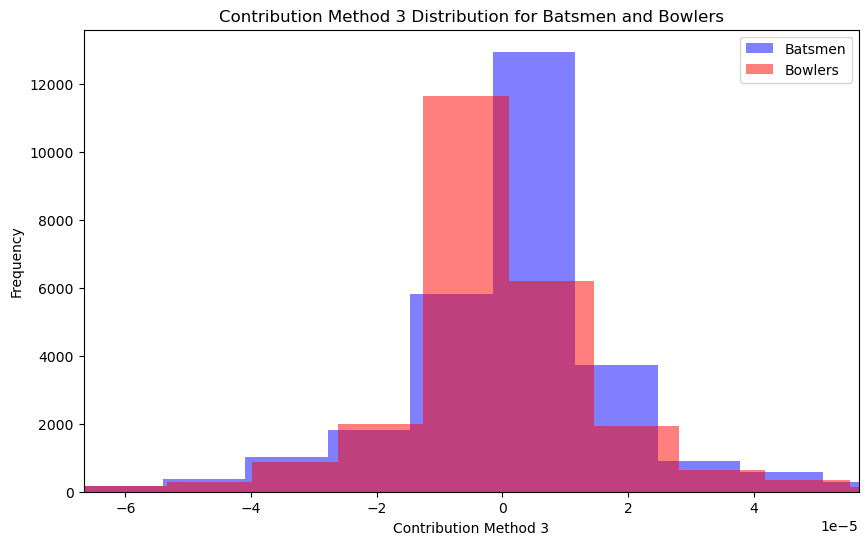

In [39]:
import matplotlib.pyplot as plt

def visualize_contribution_distribution_histogram(combined_data_with_contributions):
    # Filter out batsmen and bowlers data separately
    batsmen_data = combined_data_with_contributions[combined_data_with_contributions['Role'] == 'Batsman']
    bowlers_data = combined_data_with_contributions[combined_data_with_contributions['Role'] == 'Bowler']
    
    # Create a figure object
    plt.figure(figsize=(10, 6))

    # Plot the histogram for batsmen's contributions, increasing the number of bins to 200
    plt.hist(batsmen_data['Contribution_method3'], bins=200, alpha=0.5, label='Batsmen', color='blue')

    # Plot the histogram for bowlers' contributions, increasing the number of bins to 200
    plt.hist(bowlers_data['Contribution_method3'], bins=200, alpha=0.5, label='Bowlers', color='red')
    
    # Add title and labels
    plt.title('Contribution Method 3 Distribution for Batsmen and Bowlers')
    plt.xlabel('Contribution Method 3')
    plt.ylabel('Frequency')

    # Limit the x-axis to show only the range between the 2nd and 98th percentile of contributions, leaving out some outliers
    plt.xlim([combined_data_with_contributions['Contribution_method3'].quantile(0.02),
              combined_data_with_contributions['Contribution_method3'].quantile(0.98)])
    
    # Add legend
    plt.legend()

    # Display the plot
    plt.show()

# Call the function to visualize the histogram
visualize_contribution_distribution_histogram(combined_data_with_contributions)
